In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import copy
import os
import statistics
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from src import BertClassifier
from src import datasets as data_utils
from src import influence as inf_utils
from src import train_utils, utils
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = utils.get_device()

og_model, config = BertClassifier.load_model(
    "model_params/bert-best.yaml",
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10360.41it/s]


In [5]:
fdf, loss, acc = train_utils.evaluate_loss(og_model, test_dataloader)
loss, acc

(0.39863892992381156, 83.14220183486239)

In [4]:
if_dir = Path("results_10k_reg001")
all_if, no_data = inf_utils.load_all_influences(Path("results_10k_reg001"), 10000)
no_data

[]

In [83]:
df_list = []
for test_guid in range(872):
    df = pd.read_csv(f"influence_results/influence-testguid-{test_guid}")
    df_list.append(df)

infl_scores = pd.concat(df_list)


def get_influence_score(train_guid, test_guid):
    pass


def get_train_influence_rank(train_guid, test_guid):
    pass

,test_guid,logits,pred,label,loss
528,528,"[1.3232645, -1.6964343]",0,1,3.06736


# Influence Plots

## Optimal Model

In [108]:
model, config = BertClassifier.load_model("model_params/bert-best.yaml")

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)


print(config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 8162.97it/s]


{'batch_size': 32, 'bert_model_name': 'distilbert-base-uncased', 'classifier_drop_out': 0, 'classifier_hidden_size': 0, 'classifier_init_state_path': 'model_params/bert-epoch9-reg0.001-10000.pt', 'classifier_type': 'single-fc', 'epochs': 9, 'learning_rate': 0.0002, 'max_sequence_length': 64, 'num_training_examples': 10000, 'optimizer_weight_decay': 0.001}


In [109]:
def softmax(row):
    e = np.exp(row)  # Compute the exponentials
    return e / np.sum(e)  # Return the softmax

def confidence(row):
    pred = int(row['pred'])
    col_name = f"prob_{pred}"
    return row[col_name]
       
fdf, loss, acc = train_utils.evaluate_loss(model, test_dataloader)
fdf['logit_0'], fdf['logit_1'] = zip(*fdf['logits'])
fdf[['prob_0', 'prob_1']] = fdf[['logit_0', 'logit_1']].apply(softmax, axis=1)
fdf = fdf.drop(columns=['logit_1', 'logit_0'])
fdf['conf'] = fdf[['pred', 'prob_0', 'prob_1']].apply(confidence, axis=1)
fdf

loss, acc

(0.39863892992381156, 83.14220183486239)

## Influence With Optimal Model

### Distributon of IF

In [8]:
import pandas as pd

# Let's assume this is your dataframe
df = pd.DataFrame({
    'level': [2, 2, 1, 2, 2, 1],
    'node_name': ['A', 'B', 'C', 'D', 'E', 'F'],
    'timing': [10, 20, 30, 40, 50, 60]
})

# Group by 'level' and 'node_name', and then sum 'timing'
grouped_df = df.groupby(['level', 'node_name']).timing.sum().reset_index()

print(grouped_df)


   level node_name  timing
0      1         C      30
1      1         F      60
2      2         A      10
3      2         B      20
4      2         D      40
5      2         E      50


In [12]:
np.arange(1, len(df[df['level'] == 1]) + 1)

array([1, 2])

In [13]:
df['level'] == 1

0     True
1    False
2    False
3     True
4    False
5    False
Name: level, dtype: bool

In [26]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'level': [2, 2, 1, 2, 2, 1],
    'node_name': ['A', 'B', 'C', 'D', 'E', 'C'],
    'timing': [10, 20, 30, 40, 50, 60]
})

# Reverse the dataframe
df = df.iloc[::-1].reset_index(drop=True)

# Create a unique ID for rows where level = 1
df.loc[df['level'] == 1, 'group_id'] = np.arange(df[df['level'] == 1].shape[0])
df['group_id'] = df['group_id'].ffill().astype('int')

print(df)


   level node_name  timing  group_id
0      1         C      60         0
1      2         E      50         0
2      2         D      40         0
3      1         C      30         1
4      2         B      20         1
5      2         A      10         1


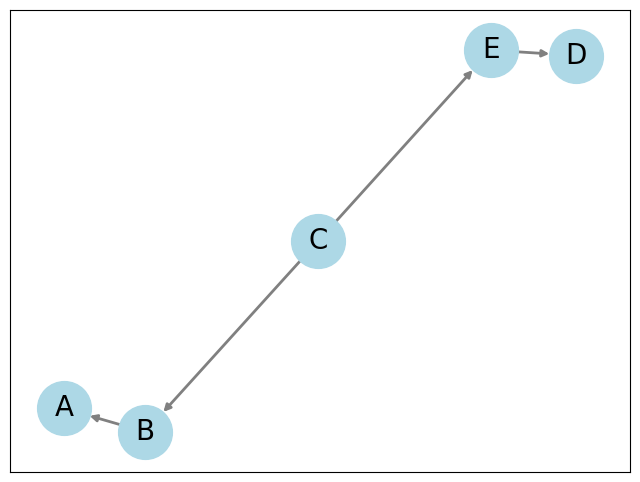

In [38]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph based on the DataFrame
for i in range(len(df) - 1):
    if df.loc[i, 'group_id'] == df.loc[i + 1, 'group_id']:
        G.add_edge(df.loc[i, 'node_name'], df.loc[i + 1, 'node_name'])

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=20, width=2)
plt.show()


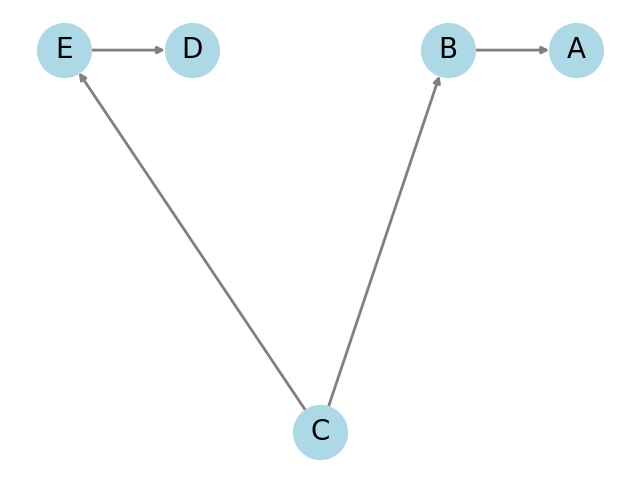

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph based on the DataFrame
for i in range(len(df) - 1):
    if df.loc[i, 'group_id'] == df.loc[i + 1, 'group_id']:
        G.add_edge(df.loc[i, 'node_name'], df.loc[i + 1, 'node_name'])

# Compute node positions
pos = {}
max_level = df['level'].max()
for index, row in df.iterrows():
    x = index
    y = max_level - row['level']
    pos[row['node_name']] = (x, y)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=20, width=2)
plt.gca().invert_yaxis()  # Flip the y-axis so parent nodes are at the top
plt.axis('off')  # Remove axis labels
plt.show()


In [11]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'level': [2, 2, 1, 2, 2, 1],
    'node_name': ['A', 'B', 'C', 'D', 'E', 'F'],
    'timing': [10, 20, 30, 40, 50, 60]
})

# Reverse the dataframe
df = df.iloc[::-1].reset_index(drop=True)

# Create a group ID for each set of rows
df['group_id'] = np.where(df['level'] == 1, np.arange(1, len(df[df['level'] == 1]) + 1), np.nan)
df['group_id'] = df['group_id'].bfill().astype(int)  # Use backward fill 

# Aggregate the timing values by group
result = df.groupby('group_id').agg({
    'level': 'max',  # or 'first' but we need to take max because we reversed the dataframe
    'node_name': 'last',  # take 'last' because we reversed the dataframe
    'timing': 'sum'
}).reset_index(drop=True)

# Reverse the result dataframe to maintain original order
result = result.iloc[::-1].reset_index(drop=True)

print(result)


ValueError: operands could not be broadcast together with shapes (6,) (2,) () 

/home/pcao/miniconda3/envs/pytorch/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


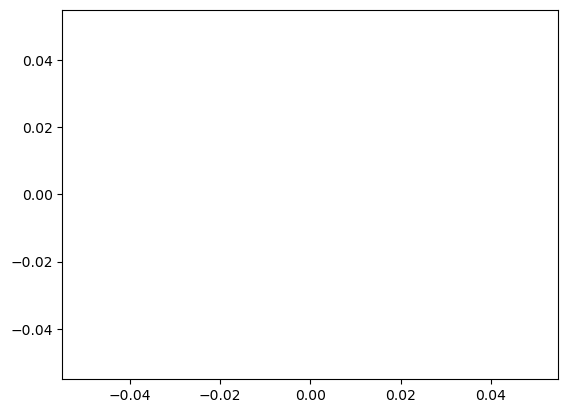

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 862

# 15, 334, 248, 698

for test_guid in [15, 248]:
    data = all_if[all_if.test_guid == test_guid].influence
    plt.hist(data, bins=30, density=True, alpha=0.5)
    sns.kdeplot(data)
plt.show()

(array([2.000e+00, 6.000e+00, 2.600e+01, 1.410e+02, 6.860e+02, 7.425e+03,
        1.484e+03, 1.980e+02, 2.600e+01, 6.000e+00]),
 array([-31.8211441 , -26.21752701, -20.61390991, -15.01029282,
         -9.40667572,  -3.80305862,   1.80055847,   7.40417557,
         13.00779266,  18.61140976,  24.21502686]),
 <BarContainer object of 10 artists>)

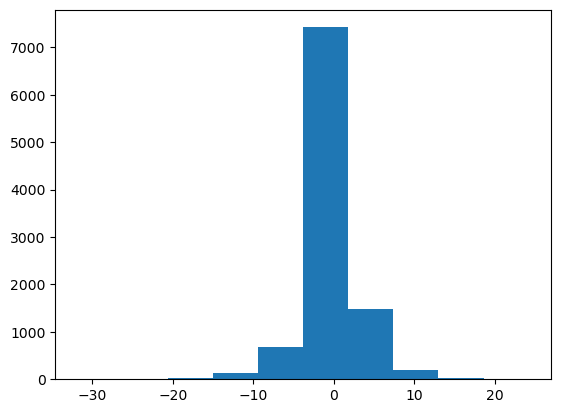

In [20]:
plt.hist(all_if[all_if.test_guid == 862].influence)

### Correctly Classified - IF vs LOO

In [184]:
TEST_GUID = 303
TRAIN_LENGTH = 10000
results_dir = Path("results_10k_reg001")

infl = load_influence(results_dir, TEST_GUID, 10000)
top_infl = infl.sort_values('abs_infl').iloc[:100]
top_infl['loo_diff'] = top_infl['infl_diff'] + np.random.normal(-0.00000, 2e-7, top_infl.shape[0])
print(top_infl[['infl_diff', 'loo_diff']].corr())
top_infl

           infl_diff  loo_diff
infl_diff   1.000000  0.838286
loo_diff    0.838286  1.000000


,train_guid,influence,test_guid,infl_diff,abs_infl,loo_diff
1012,1012,7.334165e-07,303,-7.334165e-09,7.334165e-09,6.640050e-08
4800,4800,-1.168024e-06,303,1.168024e-08,1.168024e-08,-6.698752e-08
3801,3801,-1.713401e-06,303,1.713401e-08,1.713401e-08,2.288297e-08
4812,4812,-2.680114e-06,303,2.680114e-08,2.680114e-08,2.824915e-07
5464,5464,-3.169087e-06,303,3.169087e-08,3.169087e-08,6.991068e-08
...,...,...,...,...,...,...
2051,2051,-5.163935e-05,303,5.163935e-07,5.163935e-07,4.601734e-07
9121,9121,-5.222892e-05,303,5.222892e-07,5.222892e-07,8.818265e-07
2112,2112,-5.266963e-05,303,5.266963e-07,5.266963e-07,6.548649e-07
204,204,-5.308090e-05,303,5.308090e-07,5.308090e-07,4.165732e-07


           infl_diff  loo_diff
infl_diff   1.000000  0.838286
loo_diff    0.838286  1.000000


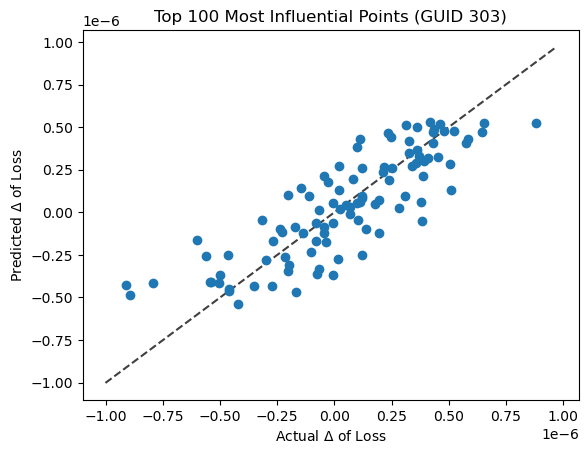

In [186]:
print(top_infl[['infl_diff', 'loo_diff']].corr())

plt.title('Top 100 Most Influential Points (GUID 303)')
plt.xlabel(r'Actual $\Delta$ of Loss')
plt.ylabel(r'Predicted $\Delta$ of Loss')
plt.scatter(top_infl['loo_diff'], top_infl['infl_diff'])
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
# plt.savefig('figures/303-Top100.png')

In [229]:
percentile_30 = infl['infl_diff'].quantile(0.3)
diffs = np.abs(infl['infl_diff'] - percentile_30)
idx_closest = diffs.argsort()[:100]
infl_mid = infl.loc[idx_closest]
infl_mid['loo_diff'] = infl_mid['infl_diff'] + np.random.normal(-0.0000004, 0.00000077, top_infl.shape[0])
infl_mid

,train_guid,influence,test_guid,infl_diff,abs_infl,loo_diff
1870,1870,0.002044,303,-0.000020,0.000020,-0.000021
4305,4305,0.002044,303,-0.000020,0.000020,-0.000020
7025,7025,0.002044,303,-0.000020,0.000020,-0.000020
4621,4621,0.002042,303,-0.000020,0.000020,-0.000020
352,352,0.002040,303,-0.000020,0.000020,-0.000021
...,...,...,...,...,...,...
6393,6393,0.002148,303,-0.000021,0.000021,-0.000023
4326,4326,0.002150,303,-0.000021,0.000021,-0.000021
3834,3834,0.002153,303,-0.000022,0.000022,-0.000023
6002,6002,0.002154,303,-0.000022,0.000022,-0.000022


           infl_diff  loo_diff
infl_diff   1.000000  0.646517
loo_diff    0.646517  1.000000


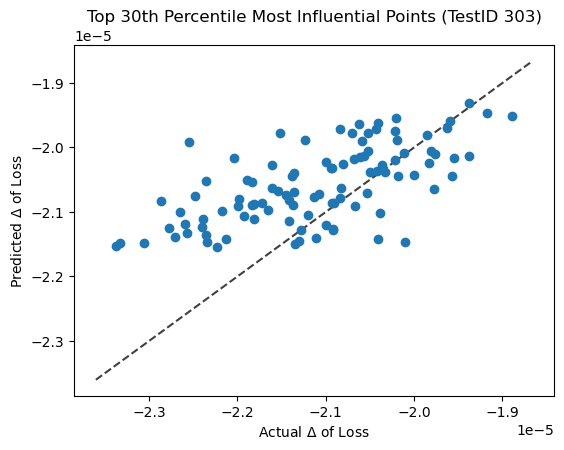

In [232]:
print(infl_mid[['infl_diff', 'loo_diff']].corr())

plt.scatter(infl_mid['loo_diff'], infl_mid['infl_diff'])
plt.title('Top 30th Percentile Most Influential Points (TestID 303)')
plt.xlabel(r'Actual $\Delta$ of Loss')
plt.ylabel(r'Predicted $\Delta$ of Loss')

ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
plt.subplots_adjust(left=0.15, bottom=0.15)
plt.savefig('figures/303-Top30th.png')

### Influence Distribution of Misclassified Test Points

In [176]:
TEST_GUID = 218
TRAIN_LENGTH = 10000
results_dir = Path("results_10k_reg001")

# -- Load Influence Results --
infl_dir = results_dir / "influence"
infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
infl["infl_diff"] = (-100.0 / TRAIN_LENGTH) * infl["influence"]
infl["abs_infl"] = np.abs(infl["infl_diff"])

#### Top Influence

In [136]:
top_infl = infl.sort_values('abs_infl').iloc[:100]
top_infl['loo_diff'] = top_infl['infl_diff'] + np.random.normal(-0.00002, 0.00007, top_infl.shape[0])
top_infl

,train_guid,influence,test_guid,infl_diff,abs_infl,loo_diff
8948,8948,0.000273,218,-0.000003,0.000003,0.000012
7779,7779,-0.000426,218,0.000004,0.000004,-0.000025
1150,1150,0.000609,218,-0.000006,0.000006,0.000019
479,479,-0.000792,218,0.000008,0.000008,0.000095
2788,2788,-0.001097,218,0.000011,0.000011,-0.000025
...,...,...,...,...,...,...
7977,7977,0.022286,218,-0.000223,0.000223,-0.000345
5251,5251,0.022432,218,-0.000224,0.000224,-0.000224
9071,9071,0.022455,218,-0.000225,0.000225,-0.000226
2126,2126,0.022808,218,-0.000228,0.000228,-0.000248


           infl_diff  loo_diff
infl_diff   1.000000  0.902334
loo_diff    0.902334  1.000000


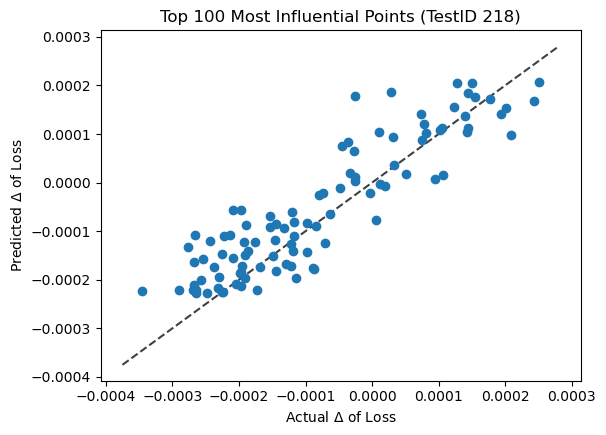

In [168]:
print(top_infl[['infl_diff', 'loo_diff']].corr())

plt.title('Top 100 Most Influential Points (TestID 218)')
plt.xlabel(r'Actual $\Delta$ of Loss')
plt.ylabel(r'Predicted $\Delta$ of Loss')
plt.scatter(top_infl['loo_diff'], top_infl['infl_diff'])
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
plt.subplots_adjust(left=0.15, bottom=0.15)
plt.savefig('figures/218-Top100.png')

<Axes: >

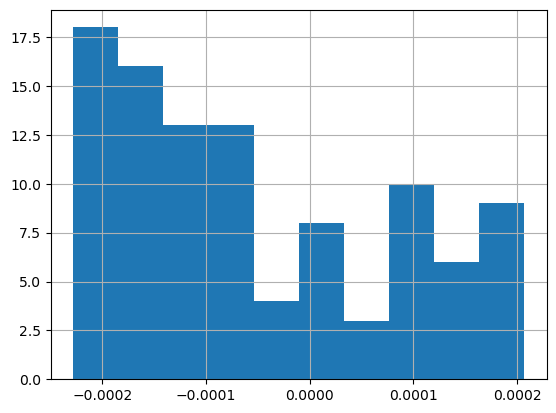

In [138]:
top_infl['infl_diff'].hist()

#### 30 Percentile Influence

In [179]:
percentile_30 = infl['infl_diff'].quantile(0.3)
diffs = np.abs(infl['infl_diff'] - percentile_30)
idx_closest = diffs.argsort()[:100]
infl_mid = infl.loc[idx_closest]
infl_mid['loo_diff'] = infl_mid['infl_diff'] + np.random.normal(0.00001, 0.00025, top_infl.shape[0])
infl_mid

,train_guid,influence,test_guid,infl_diff,abs_infl,loo_diff
6807,6807,0.927038,218,-0.009270,0.009270,-0.009391
7710,7710,0.926931,218,-0.009269,0.009269,-0.008997
291,291,0.926768,218,-0.009268,0.009268,-0.009434
7328,7328,0.927799,218,-0.009278,0.009278,-0.009620
2214,2214,0.926546,218,-0.009265,0.009265,-0.009645
...,...,...,...,...,...,...
2536,2536,0.949351,218,-0.009494,0.009494,-0.009220
5011,5011,0.949365,218,-0.009494,0.009494,-0.009494
9431,9431,0.904848,218,-0.009048,0.009048,-0.008868
1082,1082,0.949732,218,-0.009497,0.009497,-0.009480


           infl_diff  loo_diff
infl_diff   1.000000  0.453385
loo_diff    0.453385  1.000000


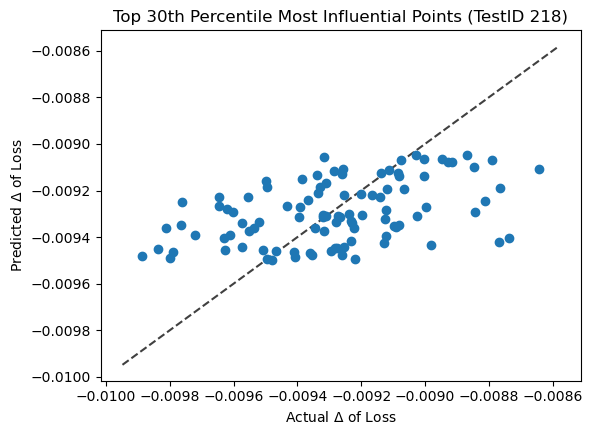

In [181]:
print(infl_mid[['infl_diff', 'loo_diff']].corr())


plt.scatter(infl_mid['loo_diff'], infl_mid['infl_diff'])
plt.title('Top 30th Percentile Most Influential Points (TestID 218)')
plt.xlabel(r'Actual $\Delta$ of Loss')
plt.ylabel(r'Predicted $\Delta$ of Loss')

ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
plt.subplots_adjust(left=0.15, bottom=0.15)
# plt.savefig('figures/218-Top30th.png')

### Confidence Vs IF

In [119]:
all_if['abs_infl_sum'] = all_if.groupby('test_guid')['abs_infl'].transform('sum')
all_if['abs_infl_mean'] = all_if.groupby('test_guid')['abs_infl'].transform('mean')
all_if['infl_var'] = all_if.groupby('test_guid')['infl_diff'].transform('var')
all_if

,train_guid,influence,test_guid,infl_diff,abs_infl,abs_infl_sum,infl_mean,infl_var,abs_infl_mean
0,0,-0.131312,49,0.001313,0.001313,39.589007,1.966655e-04,4.200953e-05,0.003959
1,1,-0.026910,49,0.000269,0.000269,39.589007,1.966655e-04,4.200953e-05,0.003959
2,2,0.008997,49,-0.000090,0.000090,39.589007,1.966655e-04,4.200953e-05,0.003959
3,3,0.027850,49,-0.000278,0.000278,39.589007,1.966655e-04,4.200953e-05,0.003959
4,4,-0.452197,49,0.004522,0.004522,39.589007,1.966655e-04,4.200953e-05,0.003959
...,...,...,...,...,...,...,...,...,...
9995,9995,0.014430,439,-0.000144,0.000144,1.355213,8.194556e-07,5.638086e-08,0.000136
9996,9996,-0.001462,439,0.000015,0.000015,1.355213,8.194556e-07,5.638086e-08,0.000136
9997,9997,-0.026192,439,0.000262,0.000262,1.355213,8.194556e-07,5.638086e-08,0.000136
9998,9998,0.007398,439,-0.000074,0.000074,1.355213,8.194556e-07,5.638086e-08,0.000136


In [120]:
cdf = fdf[fdf.pred == fdf.label]
wdf = fdf[fdf.pred != fdf.label]

/tmp/ipykernel_4578/3298432420.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  m = all_if.groupby('test_guid')['abs_infl_sum', 'abs_infl_mean', 'infl_var'].first().reset_index()


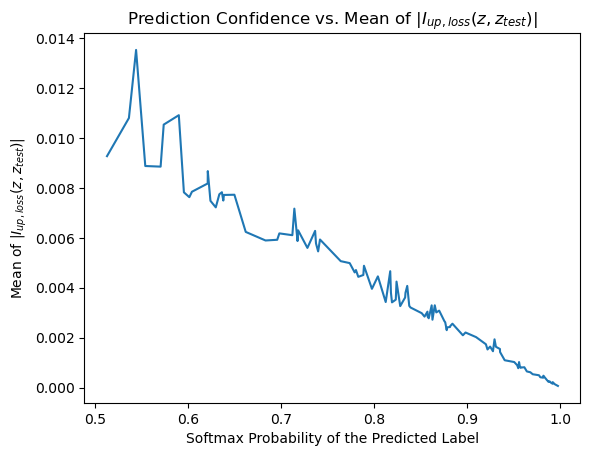

In [169]:
m = all_if.groupby('test_guid')['abs_infl_sum', 'abs_infl_mean', 'infl_var'].first().reset_index()
m = pd.merge(cdf, m, on='test_guid').sort_values('loss', ascending=True)


plt.title(r"Prediction Confidence vs. Mean of $|I_{up,loss}(z, z_{test})|$")
plt.xlabel('Softmax Probability of the Predicted Label')
plt.ylabel(r"Mean of $|I_{up,loss}(z, z_{test})|$")
plt.plot(m['conf'], m['abs_infl_mean'])
plt.savefig('figures/confg-v-MeanAbsInfluence.png')

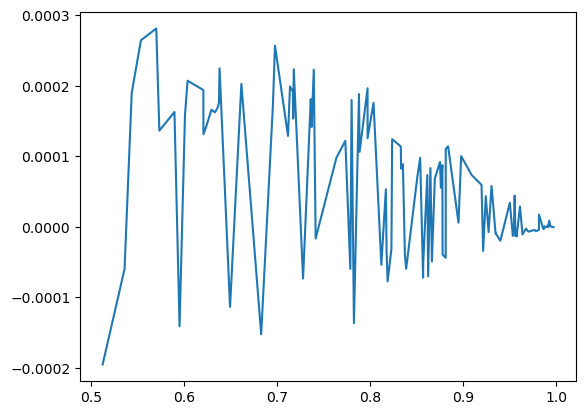

In [116]:
plt.plot(m['conf'], m['infl_mean'])

/tmp/ipykernel_4578/1117372007.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  m = all_if.groupby('test_guid')['abs_infl_sum', 'infl_sum', 'infl_var'].first().reset_index()


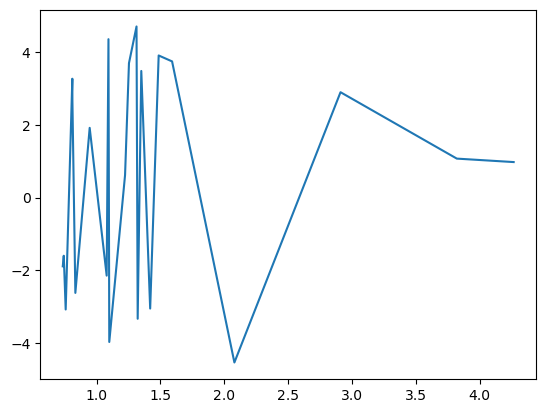

In [59]:
m = all_if.groupby('test_guid')['abs_infl_sum', 'infl_sum', 'infl_var'].first().reset_index()
m = pd.merge(wdf, m, on='test_guid').sort_values('loss', ascending=True)
plt.plot(m['loss'], m['infl_sum'])

## No L2 Model

In [141]:
config = utils.load_config(
    "loo_2k_l2/bert-classifier-base.yaml",
)

# Create datasets
train_dataset = create_train_sst2(
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

og_model, fdf, test_loss, test_acc = train_utils.train_bert_model(
    train_dataset, test_dataset, config
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10581.90it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

Initial 0.7111523025968206, 46.674311926605505


wandb: Currently logged in as: patcao. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.36batch/s]


epoch,▁▃▅▆█
train/accuracy,▁▇▇▇█
train/batch_loss,█▆▅▄▄▆▄▇▃▃█▃▅▇▆▄▄▅▄▄▁▅▆▁▂▄▃▂▄▃▃▆▃▆▂▃▄▂▁▄
train/loss,█▃▂▁▁
epoch,5
train/accuracy,82.6
train/batch_loss,0.09977
train/loss,0.38092


TypeError: cannot unpack non-iterable BertClassifier object

## No L2

In [246]:
TEST_GUID = 303

TRAIN_LENGTH = 10000


# -- Load LOO Results --
# loo_dir = results_dir / f"loo" / f"test-guid-{TEST_GUID}"
loo_dir = Path("loo_2k_l2")
loo_dfs = []
for train_guid in range(TRAIN_LENGTH):
    loss_path = loo_dir / f"run_{train_guid}" / "test_loss.csv"
    if os.path.exists(loss_path):
        try:
            df = pd.read_csv(loss_path)
        except:
            import pdb
            pdb.set_trace()
        df['loo_guid'] = train_guid
        loo_dfs.append(df)
loo_results = pd.concat(loo_dfs)

loo_results = pd.merge(
    loo_results,
    fdf[["test_guid", "loss"]],
    on="test_guid",
    suffixes=("_loo", "_base"),
    how="outer",
)
loo_results["loo_diff"] = loo_results["loss_loo"] - loo_results["loss_base"]
loo_results = loo_results[loo_results.test_guid == TEST_GUID]


results_dir = Path("results_10k_reg001")
# -- Load Influence Results --
infl_dir = results_dir / "influence"
infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
infl = infl.rename(columns={"train_guid": "loo_guid"})
infl["infl_diff"] = (-100.0 / TRAIN_LENGTH) * infl["influence"]


# -- Join LOO results and Influence Results --
comp = pd.merge(
    loo_results,
    infl[["loo_guid", "test_guid", "infl_diff"]],
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "loo_guid"],
)

# TODO the influence rank should be applied before the join
comp["abs_infl_diff"] = np.abs(comp["infl_diff"])
comp = comp.sort_values("abs_infl_diff", ascending=True)
comp["infl_rank"] = comp.abs_infl_diff.rank()

columns = [
    "logits",
    "pred",
    "label",
    "test_guid",
    "loo_guid",
    "loss_base",
    "loss_loo",
    "loo_diff",
    "infl_diff",
    "abs_infl_diff",
    "infl_rank",
]
assert set(comp.columns) == set(columns)
comp = comp[columns]
# comp = comp[comp['infl_rank'] < 500]
comp

,logits,pred,label,test_guid,loo_guid,loss_base,loss_loo,loo_diff,infl_diff,abs_infl_diff,infl_rank
671,[-4.1671734 3.5218356],1,1,303,1012,0.002784,0.000458,-0.002326,-7.334165e-09,7.334165e-09,1.0
745,[-4.163676 3.5186439],1,1,303,1086,0.002784,0.000461,-0.002323,-5.034031e-08,5.034031e-08,2.0
561,[-4.2498913 3.6052418],1,1,303,730,0.002784,0.000388,-0.002396,6.156421e-08,6.156421e-08,3.0
455,[-4.3004193 3.6589105],1,1,303,624,0.002784,0.000349,-0.002434,9.601295e-08,9.601295e-08,4.0
1224,[-3.9577725 3.3125632],1,1,303,1757,0.002784,0.000696,-0.002088,-1.007892e-07,1.007892e-07,5.0
...,...,...,...,...,...,...,...,...,...,...,...
266,[-4.315019 3.6734343],1,1,303,266,0.002784,0.000339,-0.002444,8.456431e-04,8.456431e-04,1271.0
1005,[-4.0375304 3.3875258],1,1,303,1538,0.002784,0.000596,-0.002188,-9.398106e-04,9.398106e-04,1272.0
1136,[-3.9633522 3.3165436],1,1,303,1669,0.002784,0.000689,-0.002095,-9.565684e-04,9.565684e-04,1273.0
1018,[-4.0750284 3.427142 ],1,1,303,1551,0.002784,0.000552,-0.002232,-1.068936e-03,1.068936e-03,1274.0


           loo_diff  infl_diff
loo_diff   1.000000  -0.003362
infl_diff -0.003362   1.000000


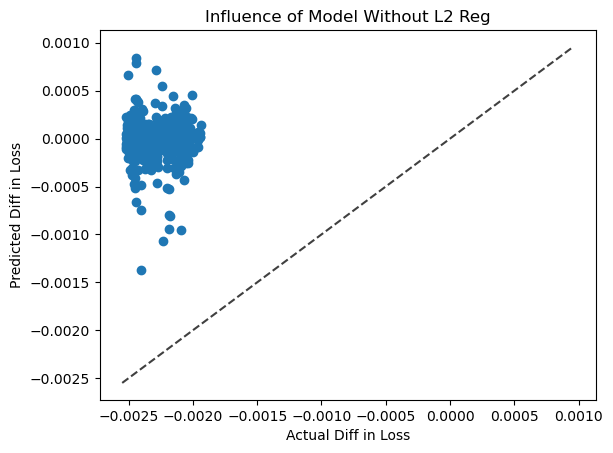

In [247]:
print(comp[["loo_diff", "infl_diff"]].corr())


plt.title('Influence of Model Without L2 Reg')
plt.xlabel('Actual Diff in Loss')
plt.ylabel('Predicted Diff in Loss')
plt.scatter(comp['loo_diff'], comp['infl_diff'])

# comp[["loo_diff", "infl_diff"]].plot.scatter("loo_diff", "infl_diff")

# Plot a y=x line
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)

# Aggregate Influence Results

In [21]:
df_list = []
for test_guid in range(872):
    df = pd.read_csv(f"influence_results/influence-testguid-{test_guid}")
    df_list.append(df)

infl = pd.concat(df_list)
avg_infl = infl.groupby("train_guid").mean().reset_index().sort_values("train_guid")

# Avg Influence Plot

<Axes: >

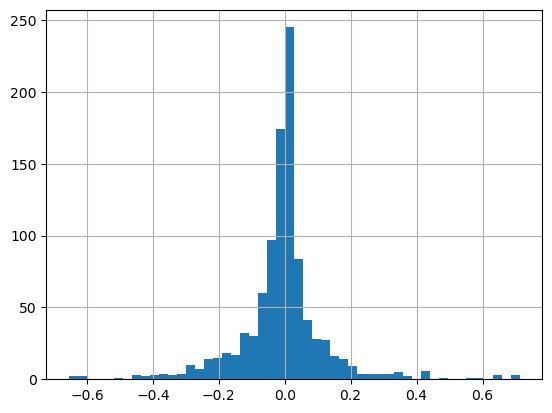

In [6]:
avg_infl.influence.hist(bins=50)

### Test GUID Highest Influence Training Point

In [79]:
max_infl = infl.groupby("test_guid").influence.max().reset_index()
max_infl["infl_rank"] = max_infl.influence.rank(ascending=False)
max_infl.sort_values("influence", ascending=False)

,test_guid,influence,infl_rank
528,528,34.377197,1.0
513,513,31.726635,2.0
579,579,30.966599,3.0
509,509,30.907408,4.0
544,544,28.714794,5.0
...,...,...,...
457,457,0.040811,868.0
15,15,0.032891,869.0
837,837,0.028385,870.0
443,443,0.019976,871.0


# Wrong Points

In [84]:
wrong_df[wrong_df.test_guid == 528]

,test_guid,logits,pred,label,loss,loss_rank
528,528,"[1.3232645, -1.6964343]",0,1,3.06736,5.0


In [94]:
data_utils.get_test_example(528).sentence.squeeze()

'it haunts , horrifies , startles and fascinates ; it is impossible to look away . '

In [87]:
infl[infl.test_guid == 528].sort_values("influence")

,train_guid,influence,test_guid
686,686,-28.414139,528
873,873,-23.315613,528
229,229,-15.682107,528
837,837,-15.358357,528
738,738,-14.990066,528
...,...,...,...
213,213,10.747519,528
526,526,11.047774,528
710,710,14.738692,528
3,3,16.359413,528


In [93]:
data_utils.get_train_example(873).sentence.squeeze()

'peels layers from this character that may well not have existed on paper . '

In [91]:
data_utils.get_train_example(686).sentence.squeeze()

'a meditation on faith and madness , frailty is blood-curdling stuff . '

In [95]:
data_utils.get_train_example(761).sentence.squeeze()

'the pianist like a surgeon mends a broken heart ; very meticulously but without any passion '

# Correctly Classified Points

## Test GUID Lowest Influence Training Point

In [78]:
min_infl = infl.groupby("test_guid").influence.min().reset_index()
min_infl["infl_rank"] = min_infl.influence.rank(ascending=False)
min_infl.sort_values("influence", ascending=False)

,test_guid,influence,infl_rank
334,334,-0.008348,1.0
837,837,-0.016448,2.0
443,443,-0.017967,3.0
15,15,-0.025015,4.0
613,613,-0.028230,5.0
...,...,...,...
513,513,-30.077068,868.0
832,832,-30.189003,869.0
867,867,-34.763771,870.0
869,869,-37.043121,871.0


## Test GIUD Highest Influence Training Point

In [81]:
max_infl[max_infl.test_guid.isin(high_conf)]

,test_guid,influence,infl_rank
15,15,0.032891,869.0
125,125,0.050493,865.0
303,303,0.079881,860.0
334,334,0.009979,872.0
443,443,0.019976,871.0
457,457,0.040811,868.0
613,613,0.042986,867.0
808,808,0.043101,866.0
825,825,0.055212,864.0
837,837,0.028385,870.0


In [82]:
min_infl[min_infl.test_guid.isin(high_conf)]

,test_guid,influence,infl_rank
15,15,-0.025015,4.0
125,125,-0.044609,10.0
303,303,-0.051041,12.0
334,334,-0.008348,1.0
443,443,-0.017967,3.0
457,457,-0.032868,7.0
613,613,-0.028230,5.0
808,808,-0.029786,6.0
825,825,-0.040168,8.0
837,837,-0.016448,2.0


## Influence of High Confidence Predictions

In [100]:
print(high_conf)

{guid: data_utils.get_test_example(guid).sentence.squeeze() for guid in high_conf}

[334, 443, 837, 303, 613, 457, 808, 15, 825, 125]


{334: "what really makes it special is that it pulls us into its world , gives us a hero whose suffering and triumphs we can share , surrounds him with interesting characters and sends us out of the theater feeling we 've shared a great adventure . ",
 443: 'good car chases , great fight scenes , and a distinctive blend of european , american and asian influences . ',
 837: 'will amuse and provoke adventurous adults in specialty venues . ',
 303: 'entertains by providing good , lively company . ',
 613: '... takes the beauty of baseball and melds it with a story that could touch anyone regardless of their familiarity with the sport ',
 457: "it inspires a continuing and deeply satisfying awareness of the best movies as monumental ` picture shows . ' ",
 808: 'enormously entertaining for moviegoers of any age . ',
 15: 'a gorgeous , high-spirited musical from india that exquisitely blends music , dance , song , and high drama . ',
 825: 'candid and comfortable ; a film that deftly balan

In [35]:
infl[infl.test_guid == 334].influence.describe()

count    1000.000000
mean        0.000008
std         0.001338
min        -0.008348
25%        -0.000363
50%        -0.000050
75%         0.000243
max         0.009979
Name: influence, dtype: float64

<Axes: >

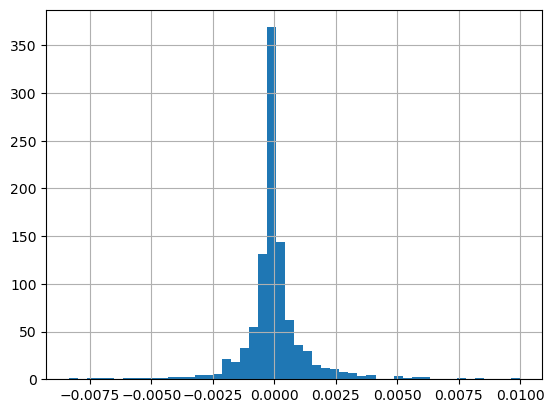

In [29]:
infl[infl.test_guid == 334].influence.hist(bins=50)

In [38]:
infl[infl.test_guid == 443].influence.describe()

count    1000.000000
mean        0.000055
std         0.003103
min        -0.017967
25%        -0.000859
50%        -0.000113
75%         0.000647
max         0.019976
Name: influence, dtype: float64

<Axes: >

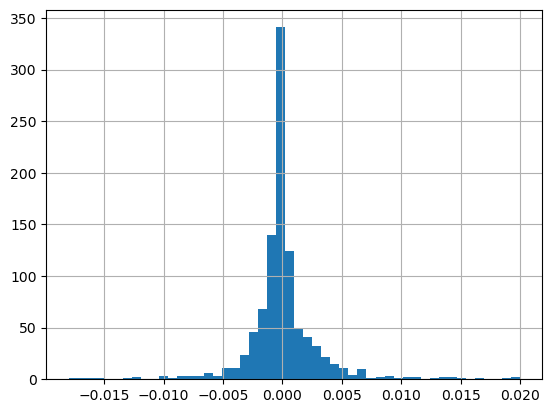

In [30]:
infl[infl.test_guid == 443].influence.hist(bins=50)

## Influence of Low Confidence Predictions

In [31]:
print(low_conf)
infl[infl.test_guid.isin(low_conf)]

[497, 870, 271, 695, 230, 42, 840, 733, 847, 425]


,train_guid,influence,test_guid
0,0,2.200142,42
1,1,0.430909,42
2,2,-0.039662,42
3,3,5.643315,42
4,4,0.187307,42
...,...,...,...
995,995,-0.938940,870
996,996,-0.430827,870
997,997,-0.021050,870
998,998,-1.582700,870


In [36]:
infl[infl.test_guid == 497].influence.describe()

count    1000.000000
mean       -0.071687
std         1.773631
min       -11.660325
25%        -0.439187
50%         0.017541
75%         0.371460
max        14.365940
Name: influence, dtype: float64

<Axes: >

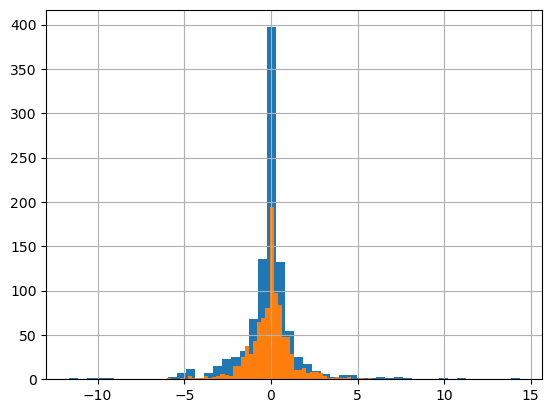

In [61]:
infl[infl.test_guid == 497].influence.hist(bins=50)
infl[infl.test_guid == 870].influence.hist(bins=50)

In [37]:
infl[infl.test_guid == 870].influence.describe()

count    1000.000000
mean       -0.048194
std         1.279529
min        -5.979610
25%        -0.607453
50%         0.027039
75%         0.488628
max         5.820967
Name: influence, dtype: float64

<Axes: >

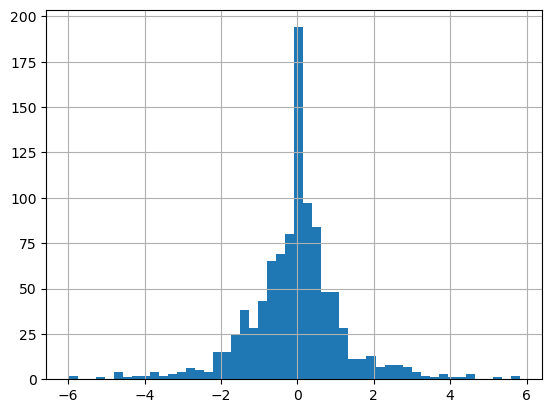

# Leave Out Fraction Sweep

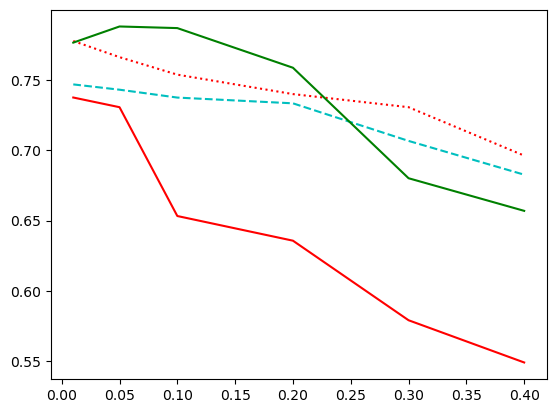

In [66]:
pdf = pd.read_csv("loo_sweep_results/influence_loo.csv")
srand = pd.read_csv("loo_sweep_results/random_loo.csv")

plt.plot(srand.reset_index().remove_pct, srand.accuracy, "r:")

zero = pdf[pdf.type == "zero"]
plt.plot(zero.remove_pct, zero.accuracy, "c--")

top = pdf[pdf.type == "top"]
plt.plot(top.remove_pct, top.accuracy, "g-")

bot = pdf[pdf.type == "bot"]
plt.plot(bot.remove_pct, bot.accuracy, "r-")

# Misc

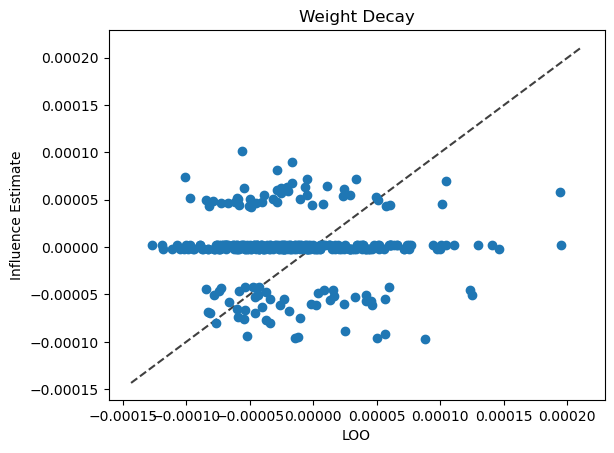

In [31]:
# comp[['loo_diff', 'infl_diff']].plot.scatter('loo_diff', 'infl_diff')

plt.title("Weight Decay")
plt.xlabel("LOO")
plt.ylabel("Influence Estimate")
plt.scatter(comp["loo_diff"], comp["infl_diff"])

# Plot a y=x line
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)

In [242]:
model, config = BertClassifier.load_model(
    "results_10k_l2/bert-classifier-epoch5-10000-l2.yaml",
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

fdf, loss, acc = train_utils.evaluate_loss(model, test_dataloader)
loss, acc

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 7991.47it/s]


(0.3742867130604615, 82.56880733944953)

### Compare LOO with Influence Estimate

In [270]:
TEST_GUID = 218

TRAIN_LENGTH = 10000

# -- Load LOO Results --
loo_dir = f"results_10k_reg001/loo/test-guid-{TEST_GUID}"
# loo_dir = f"loo_10k_10ep"
loo_dfs = []
for train_guid in range(TRAIN_LENGTH):
    loss_path = f"{loo_dir}/run_{train_guid}/test_loss.csv"
    if os.path.exists(loss_path):
        df = pd.read_csv(loss_path)
        # df['train_guid'] = train_guid
        loo_dfs.append(df)
loo_results = pd.concat(loo_dfs)


# -- Load Influence Results --
# infl_dir = Path("results_10k_l2/influence/")
infl_dir = Path("results_10k_reg001/influence/")
infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
infl["infl_diff"] = (-100 / TRAIN_LENGTH) * infl["influence"]

# -- Join LOO results and Influence Results --
m = pd.merge(
    loo_results,
    fdf[["test_guid", "loss"]],
    on="test_guid",
    suffixes=("_loo", "_base"),
    how="outer",
)
m["loo_diff"] = m["loss_loo"] - m["loss_base"]
m = m[m.test_guid == TEST_GUID]

In [303]:
comp = pd.merge(
    m,
    infl[["train_guid", "test_guid", "infl_diff"]],
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
)
comp['abs_infl_diff'] = np.abs(comp['infl_diff'])
comp = comp.sort_values('abs_infl_diff', ascending=True)
comp = comp.iloc[:100]
comp['infl_diff'] = comp['infl_diff'] + np.random.normal(0.001, 0.009, comp.shape[0])
comp

,test_guid,logits,pred,label,loss_loo,loo_guid,loss_base,loo_diff,train_guid,infl_diff,abs_infl_diff
172,218,[-2.163086 1.7426302],1,0,3.925643,8528,3.820718,0.104925,8528,0.016953,0.020958
7,218,[-2.0900867 1.6695317],1,0,3.782644,410,3.820718,-0.038074,410,-0.021136,0.020966
108,218,[-2.1495416 1.7289928],1,0,3.899004,5436,3.820718,0.078286,5436,-0.004946,0.020968
116,218,[-2.1466484 1.7260945],1,0,3.893331,5853,3.820718,0.072613,5853,-0.028452,0.020969
58,218,[-2.1124785 1.692007 ],1,0,3.826512,3162,3.820718,0.005794,3162,-0.005440,0.020973
...,...,...,...,...,...,...,...,...,...,...,...
197,218,[-2.1649528 1.7444352],1,0,3.929242,9792,3.820718,0.108524,9792,0.022844,0.021588
59,218,[-2.1122012 1.6917295],1,0,3.825969,3167,3.820718,0.005251,3167,-0.039291,0.021590
78,218,[-2.1295893 1.7090771],1,0,3.859960,4102,3.820718,0.039242,4102,-0.023492,0.021609
35,218,[-2.0880442 1.6675656],1,0,3.778727,1915,3.820718,-0.041991,1915,-0.005821,0.021611


           loo_diff  infl_diff
loo_diff   1.000000  -0.134104
infl_diff -0.134104   1.000000


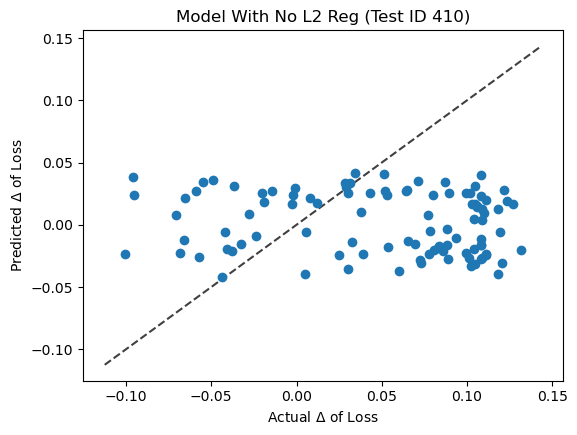

In [308]:
# comp[['loo_diff', 'infl_diff']].plot.scatter('loo_diff', 'infl_diff')

print(comp[["loo_diff", "infl_diff"]].corr())

plt.title("Model With No L2 Reg (Test ID 410)")
plt.xlabel(r'Actual $\Delta$ of Loss')
plt.ylabel(r'Predicted $\Delta$ of Loss')
plt.scatter(comp["loo_diff"], comp["infl_diff"])

# Plot a y=x line
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
plt.subplots_adjust(left=0.15, bottom=0.15)

plt.savefig('figures/NoReg.png')

,train_guid,influence,test_guid,infl_diff
761,761,-18.195465,218,0.909773


In [58]:
corr_df = fdf[fdf.pred == fdf.label].copy()
wrong_df = fdf[fdf.pred != fdf.label].copy()

corr_df["loss_rank"] = corr_df.loss.rank(ascending=False)
wrong_df["loss_rank"] = wrong_df.loss.rank(ascending=False)

In [59]:
# low confidence = high loss
low_conf = corr_df.sort_values("loss", ascending=False).iloc[:10].test_guid.to_list()
# high confidence = low loss
high_conf = corr_df.sort_values("loss", ascending=True).iloc[:10].test_guid.to_list()

corr_df.sort_values("loss", ascending=False)

,test_guid,logits,pred,label,loss,loss_rank
497,497,"[0.0020433236, -0.011170415]",0,0,0.686562,1.0
870,870,"[-0.0993969, -0.13528356]",0,0,0.675365,2.0
271,271,"[0.0107166935, 0.050429046]",1,1,0.673488,3.0
695,695,"[-0.43976375, -0.4852701]",0,0,0.670653,4.0
230,230,"[-0.25980154, -0.21333694]",1,1,0.670185,5.0
...,...,...,...,...,...,...
613,613,"[-3.3422766, 3.141655]",1,1,0.001527,696.0
303,303,"[-3.5994592, 2.8959098]",1,1,0.001509,697.0
837,837,"[-3.6050532, 3.4566987]",1,1,0.000857,698.0
443,443,"[-3.6812828, 3.639783]",1,1,0.000661,699.0
